# Size Distribution by Factor

One of the reviewer's wanted to know whether or not the PSD actually was different during periods when Factor 1 was dominant. Really, they want to know if the factors are actually separated out by size, and not by something else.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import smps
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
import matplotlib.gridspec as gridspec
import smps

sns.set("paper", "ticks", font_scale=1.25)
smps.set()

%matplotlib inline

## Load the data

In [2]:
# load the underlying scans
s = joblib.load(Path().resolve().parent.joinpath("data/munged/smps.data.munged.sav"))

# load the timeseries data for the sensor used in the main text
ts = pd.read_feather("../data/output/tata2017015/nmf-tseries-results.feather").set_index("index")

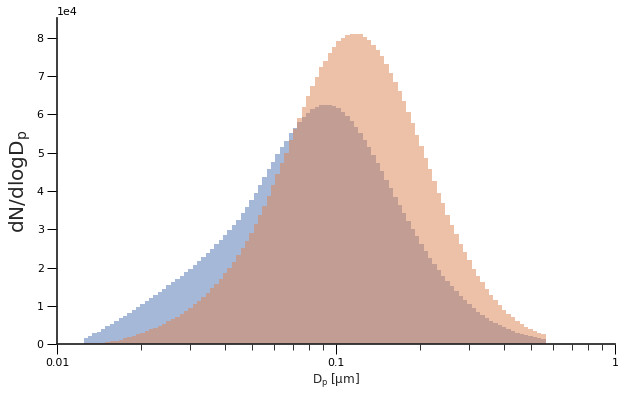

In [72]:
fig, ax = plt.subplots(1, figsize=(10, 6))

ax = smps.plots.histplot(
    s.dndlogdp["2018-01-12 13:00:00": "2018-01-12 23:00"],
    s.bins,
    plot_kws=dict(linewidth=.01, alpha=.5),
    ax=ax
)

ax = smps.plots.histplot(
    s.dndlogdp["2018-01-13 00:00": "2018-01-13 03:00"],
    s.bins,
    plot_kws=dict(linewidth=.01, alpha=.5),
    ax=ax
)

ax.set_ylabel("$dN/dlogD_p$", fontsize=20)
ax.set_xlim(0.01, 1)

sns.despine()


In [101]:
tmp = pd.merge(s.scan_stats[["Median"]], ts[["Factor 1", "Factor 2", "Factor 3"]], left_index=True, right_index=True, how='outer')

tmp = tmp.assign(
    vu380=s.integrate(weight='volume', dmin=0., dmax=0.38),
    pm1=ts["PM1_EST"]/1.2,
)

tmp = tmp.resample('15min').mean()

tmp["vo380"] = tmp["pm1"] - tmp["vu380"]

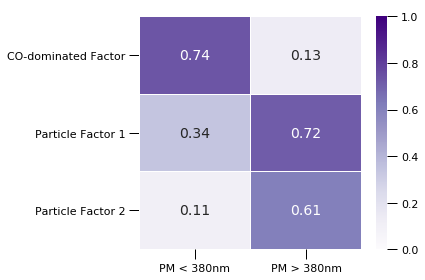

In [145]:
cols_x = ["vu380", "vo380"]
cols_y = ["Factor 1", "Factor 2", "Factor 3"]

corr = tmp.corr()**2

g = sns.heatmap(
    corr.loc[cols_y][cols_x], 
    cmap="Purples", annot=True, fmt=".2f", vmin=0, vmax=1, linewidths=0.05, annot_kws=dict(size=14))

g.set_yticklabels(["CO-dominated Factor", "Particle Factor 1", "Particle Factor 2"])
g.set_xticklabels(["PM < 380nm", "PM > 380nm", "$PM_1$"])
g.set_yticklabels(g.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig("compare-factors-by-size.png", dpi=350)